# Loading the dataset

In [3]:
import pandas as pd

# Load the CSV file named "df.csv"
df = pd.read_csv('df.csv')

# Treating the data

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA

# Load your dataset
# df = pd.read_csv("your_dataset.csv") # Uncomment and specify your dataset path

# Step 1: Ordinal Encoding for 'owners' and 'Overall Review Summary'
owners_mapping = {
    '0 .. 20,000': 1, '20,000 .. 50,000': 2, '50,000 .. 100,000': 3, '100,000 .. 200,000': 4,
    '200,000 .. 500,000': 5, '500,000 .. 1,000,000': 6, '1,000,000 .. 2,000,000': 7,
    '2,000,000 .. 5,000,000': 8, '5,000,000 .. 10,000,000': 9, '10,000,000 .. 20,000,000': 10,
    '20,000,000 .. 50,000,000': 11, '50,000,000 .. 100,000,000': 12
}
review_mapping = {
    'Overwhelmingly Negative': 1, 'Mostly Negative': 2, 'Negative': 3, 'Mixed': 4,
    'Positive': 5, 'Mostly Positive': 6, 'Very Positive': 7, 'Overwhelmingly Positive': 8
}

# Encode 'owners' and 'Overall Review Summary'
df['owners_encoded'] = df['owners'].map(owners_mapping)
df['review_summary_encoded'] = df['Overall Review Summary'].map(review_mapping)
df.drop(columns=['owners', 'Overall Review Summary'], inplace=True)

# Step 2: Feature Hashing for Multi-Label Columns ('Tags', 'Genre', 'Languages')
# Applying feature hashing with n_features=15
hasher = FeatureHasher(n_features=15, input_type='string')

# Hashing for each relevant column
for col in ['Tags', 'Genre', 'Languages']:
    hashed_features = pd.DataFrame(hasher.fit_transform(df[col].str.split(',')).toarray())
    hashed_features.columns = [f"{col}_hash_{i}" for i in range(1, 16)]
    df = pd.concat([df, hashed_features], axis=1)
    df.drop(columns=[col], inplace=True)

# Step 3: Drop Unnecessary Columns
df.drop(columns=['name', 'developer', 'publisher', 'DLC Names', 'F2P_Status'], inplace=True)

# Step 4: Targeted Transformation for Skewed Numerical Features
# Identify and transform only the highly skewed numerical columns
numeric_cols = df.select_dtypes(include=[float, int]).columns
skewed_cols = df[numeric_cols].apply(lambda x: x.skew()).loc[lambda x: x > 1].index

# Apply power transformation only on skewed columns
power_transformer = PowerTransformer(method='yeo-johnson')
df[skewed_cols] = power_transformer.fit_transform(df[skewed_cols])

# Step 5: Log Transformation for Specific Skewed Columns
# Apply log transformation to 'average_forever_playtime' and 'all_time_peak' (formerly 'peak_players')
log_transform_cols = ['average_forever_playtime', 'all_time_peak']
for col in log_transform_cols:
    if col in df.columns:
        # Replace NaN or non-positive values with a small positive number (e.g., 0.1) to avoid log errors
        df[col] = df[col].fillna(0.1).apply(lambda x: x if x > 0 else 0.1)
        # Apply log transformation
        df[col + '_log'] = np.log1p(df[col])
    else:
        print(f"Column '{col}' not found in DataFrame.")

# Step 6: Impute Missing Values using Iterative Imputer
imputer = IterativeImputer(random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Step 7: Feature Scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

# Step 8: Polynomial Features with Interaction Terms Only
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
df_poly = pd.DataFrame(poly.fit_transform(df_scaled), columns=poly.get_feature_names_out(df_scaled.columns))

# Step 9: Exclude Target Column Before PCA
# Ensure the target variable 'average_forever_playtime' and its transformations are not included in PCA
target_cols = ['average_forever_playtime', 'average_forever_playtime_log']
X = df_poly.drop(columns=target_cols, errors='ignore')  # Only keep feature columns for PCA
y = df['average_forever_playtime']  # Target variable

# Step 10: Dimensionality Reduction with PCA
pca = PCA(n_components=0.80, random_state=42)
df_pca = pd.DataFrame(pca.fit_transform(X))  # Apply PCA only on features

# Final dataset check
print("Final dataset shape after PCA:", df_pca.shape)
df_pca.head()


Final dataset shape after PCA: (6257, 311)


,0,1,2,3,4,5,6,7,8,9,...,301,302,303,304,305,306,307,308,309,310
0,-0.089229,3.055900,-0.394141,-0.923423,19.908321,-30.024433,-1.419138,12.154662,16.755027,0.764835,...,0.537810,-0.049495,0.945917,-2.332954,0.017110,0.733407,-0.336267,-0.811372,1.765557,-0.025870
1,-0.731735,2.325997,-0.245937,-0.086478,-1.788312,2.924241,0.082150,0.211213,-1.228307,-0.076727,...,0.233866,0.641584,0.631903,-1.457947,-0.046262,-1.467192,0.223462,-0.711114,-0.535866,0.991526
2,0.701055,1.279995,-0.053919,2.187264,25.911539,-31.229731,-3.380697,-11.880817,4.536021,-3.776145,...,-1.017505,2.772762,0.274460,1.126914,-0.668509,1.214713,2.862476,2.011246,2.353129,0.780306
3,5.063613,-8.899640,-0.286164,-0.808732,30.561328,-42.384036,-2.556172,-7.618732,-5.446131,-1.703818,...,1.318081,-2.260903,-1.992492,-0.449539,1.144723,-0.227496,0.527426,0.518652,-3.330204,2.343072
4,-0.625208,2.688715,-0.384554,-0.324846,14.531506,-22.985738,1.672376,6.637964,14.667959,-1.481917,...,1.543386,1.841896,0.136482,1.855406,-1.627835,0.446192,1.732926,-1.589598,-0.591008,-0.925844


In [5]:
df_pca.shape

(6257, 311)

# Linear Regression

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best Parameters for ElasticNet: {'alpha': 0.013111339374215644, 'l1_ratio': 0.3}

ElasticNet Regression Results on PCA-transformed Data:
Test MSE: 0.07350710968821474
Test RMSE: 0.27112194615747126
Test R² Score: 0.789696500587352
Test % Within ±30%: 22.603833865814696

Quintile-based Performance for ElasticNet Regression on PCA-transformed Data:
Quintile 1: R² = -72.6570, % Within ±30% = 1.99%
Quintile 2: R² = 0.0000, % Within ±30% = 6.00%
Quintile 3: R² = -13.4947, % Within ±30% = 20.80%
Quintile 4: R² = -2.2989, % Within ±30% = 24.40%
Quintile 5: R² = 0.4467, % Within ±30% = 59.76%


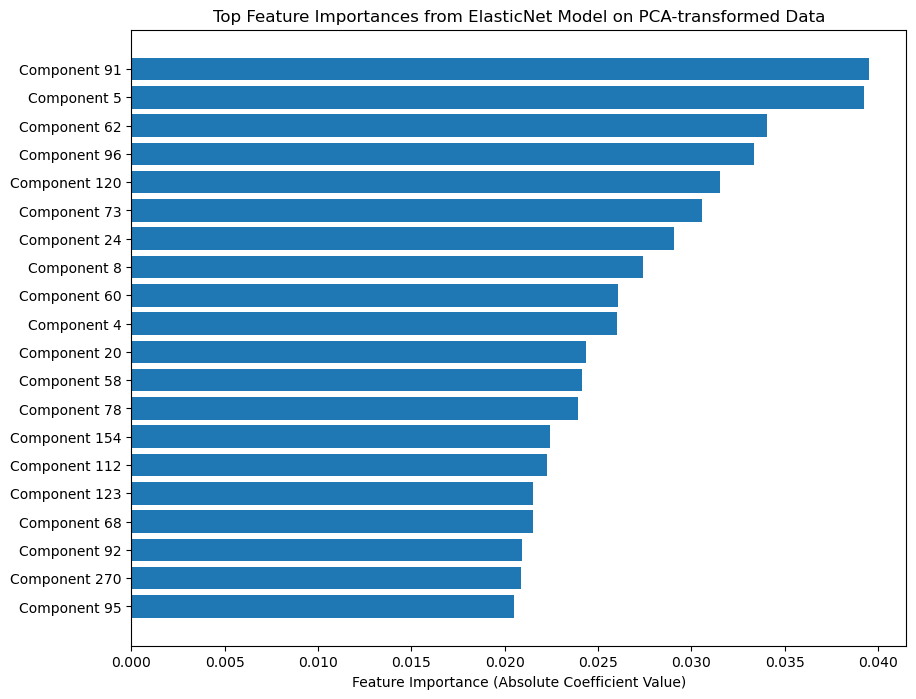

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore Convergence Warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Assume `df_pca` is your PCA-transformed feature DataFrame and `y` is the target variable
X = df_pca  # Features from the PCA-transformed DataFrame
y = df['average_forever_playtime']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expanded parameter grid for ElasticNet
param_grid = {
    'alpha': np.logspace(-4, 2, 18),       # 18 values from 0.0001 to 100
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]  # 14 values for L1/L2 balance
}

# Initialize the ElasticNet model
elasticnet = ElasticNet(random_state=42, max_iter=10000)

# Set up K-Fold Cross-Validation and Grid Search
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=elasticnet,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=kfold,
    n_jobs=-1,  # Use all available cores for faster computation
    verbose=1
)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters for ElasticNet: {best_params}")

# Predictions on test data using the best model
y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nElasticNet Regression Results on PCA-transformed Data:")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test R² Score: {r2}")

# Function to calculate percentage within ±30% of actual values
def percentage_within_threshold(y_true, y_pred, threshold=0.3):
    return np.mean(np.abs((y_true - y_pred) / y_true) <= threshold) * 100

percent_within_30 = percentage_within_threshold(y_test, y_pred)
print(f"Test % Within ±30%: {percent_within_30}")

# Quintile-based evaluation
y_test_noisy = y_test + np.random.normal(0, 1e-5, size=len(y_test))  # Handle duplicate boundaries in quintiles
quintiles = pd.qcut(y_test_noisy, 5, labels=False, duplicates='drop')
quintile_metrics = {}

for q in range(5):
    q_indices = (quintiles == q)
    y_q_true = y_test[q_indices]
    y_q_pred = y_pred[q_indices]
    
    # Calculate R² and % within ±30% for each quintile
    q_r2 = r2_score(y_q_true, y_q_pred)
    q_percentage_within_30 = percentage_within_threshold(y_q_true, y_q_pred)
    
    # Store metrics in a dictionary
    quintile_metrics[f'Quintile {q+1}'] = {
        'R²': q_r2,
        '% Within ±30%': q_percentage_within_30
    }

# Print quintile-based metrics
print("\nQuintile-based Performance for ElasticNet Regression on PCA-transformed Data:")
for quintile, metrics in quintile_metrics.items():
    print(f"{quintile}: R² = {metrics['R²']:.4f}, % Within ±30% = {metrics['% Within ±30%']:.2f}%")

# Display feature importance based on coefficients
feature_importances = np.abs(best_model.coef_)
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot top features by importance
top_n = min(20, len(feature_importances))  # Adjust to display up to 20 features if available
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importances[sorted_idx[:top_n]], align='center')
plt.yticks(range(top_n), [f"Component {i}" for i in sorted_idx[:top_n]])
plt.xlabel("Feature Importance (Absolute Coefficient Value)")
plt.title("Top Feature Importances from ElasticNet Model on PCA-transformed Data")
plt.gca().invert_yaxis()
plt.show()


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Assume `df_pca` is your PCA-transformed feature DataFrame and `y` is the target variable
X = df_pca  # Features from the PCA-transformed DataFrame
y = df['average_forever_playtime']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest parameter grid with expanded candidate values
param_grid = {
    'n_estimators': [100, 150, 200, 250],            # Expanded to add more values
    'max_depth': [10, 15, 20, 25],                   # Added more depth values
    'min_samples_split': [5, 10, 15, 20],            # Increased possible splits
    'min_samples_leaf': [1, 2, 4, 6],                # Additional minimum leaf values
    'max_features': ['sqrt', 0.6, 0.8, 1.0]          # Expanded feature consideration
}


# Generate all parameter combinations
param_combinations = list(itertools.product(*param_grid.values()))

# Initialize tracking variables for the best model
best_model = None
best_mse = float('inf')
best_params = None

# Set up K-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Manually iterate over each parameter combination with TQDM for progress tracking
for param_comb in tqdm(param_combinations, desc="Random Forest Parameter Tuning"):
    params = dict(zip(param_grid.keys(), param_comb))
    fold_mses = []
    
    # Perform cross-validation manually for each parameter combination
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Initialize and train the Random Forest model
        model = RandomForestRegressor(random_state=42, **params)
        model.fit(X_train_fold, y_train_fold)
        
        # Predictions and evaluation on the validation fold
        y_val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_val_pred)
        fold_mses.append(mse)
    
    # Average MSE across folds
    avg_mse = np.mean(fold_mses)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_model = model
        best_params = params

print(f"Best Parameters for Random Forest: {best_params}")

# Final evaluation on the test set with the best model
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print("\nRandom Forest Regression Results on PCA-transformed Data:")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")

# Function to calculate percentage within a specified threshold
def percentage_within_threshold(y_true, y_pred, threshold=0.3):
    return np.mean(np.abs((y_true - y_pred) / y_true) <= threshold) * 100

# Calculate error percentages within ±30%, ±50%, and ±100%
percent_within_30 = percentage_within_threshold(y_test, y_test_pred, threshold=0.3)
percent_within_50 = percentage_within_threshold(y_test, y_test_pred, threshold=0.5)
percent_within_100 = percentage_within_threshold(y_test, y_test_pred, threshold=1.0)

print(f"Test % Within ±30%: {percent_within_30}")
print(f"Test % Within ±50%: {percent_within_50}")
print(f"Test % Within ±100%: {percent_within_100}")

# Quintile-based evaluation
y_test_noisy = y_test + np.random.normal(0, 1e-5, size=len(y_test))  # Handle duplicate boundaries in quintiles
quintiles = pd.qcut(y_test_noisy, 5, labels=False, duplicates='drop')
quintile_metrics = {}

for q in range(5):
    q_indices = (quintiles == q)
    y_q_true = y_test[q_indices]
    y_q_pred = y_test_pred[q_indices]
    
    # Calculate MSE, RMSE, R², and % within thresholds for each quintile
    q_mse = mean_squared_error(y_q_true, y_q_pred)
    q_rmse = np.sqrt(q_mse)
    q_r2 = r2_score(y_q_true, y_q_pred)
    q_percentage_within_30 = percentage_within_threshold(y_q_true, y_q_pred, threshold=0.3)
    q_percentage_within_50 = percentage_within_threshold(y_q_true, y_q_pred, threshold=0.5)
    q_percentage_within_100 = percentage_within_threshold(y_q_true, y_q_pred, threshold=1.0)
    
    # Store metrics in a dictionary
    quintile_metrics[f'Quintile {q+1}'] = {
        'MSE': q_mse,
        'RMSE': q_rmse,
        'R²': q_r2,
        '% Within ±30%': q_percentage_within_30,
        '% Within ±50%': q_percentage_within_50,
        '% Within ±100%': q_percentage_within_100
    }

# Print quintile-based metrics
print("\nQuintile-based Performance for Random Forest Regression on PCA-transformed Data:")
for quintile, metrics in quintile_metrics.items():
    print(f"{quintile}: MSE = {metrics['MSE']:.4f}, RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R²']:.4f}, "
          f"% Within ±30% = {metrics['% Within ±30%']:.2f}%, % Within ±50% = {metrics['% Within ±50%']:.2f}%, "
          f"% Within ±100% = {metrics['% Within ±100%']:.2f}%")

# Display feature importance based on Random Forest feature_importances_
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot top features by importance
top_n = min(20, len(feature_importances))  # Adjust to display up to 20 features if available
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importances[sorted_idx[:top_n]], align='center')
plt.yticks(range(top_n), [f"Component {i}" for i in sorted_idx[:top_n]])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances from Random Forest Model on PCA-transformed Data")
plt.gca().invert_yaxis()
plt.show()


Random Forest Parameter Tuning:   0%|                                               | 1/1024 [00:16<4:41:52, 16.53s/it]


KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np
import pandas as pd
import itertools

# Assume `df_pca` is your PCA-transformed feature DataFrame and `y` is the target variable
X = df_pca  # Features from the PCA-transformed DataFrame
y = df['average_forever_playtime']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expanded XGBoost parameter grid
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],               # Added depth levels for even more flexibility
    'learning_rate': [0.03, 0.05, 0.07, 0.1],   # Comprehensive learning rates
    'n_estimators': [150, 200, 250, 300],       # A solid range for boosting rounds
    'subsample': [0.7, 0.75, 0.8, 0.85],        # Expanded range for subsampling rates
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]    # More variety in feature sampling fractions
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

# Initialize tracking variables for the best model
best_model = None
best_mse = float('inf')
best_params = None
best_quintile_metrics = None
best_overall_percent_within_30 = 0

# Set up K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-folds for efficiency

# Function to calculate percentage within ±30% of actual values
def percentage_within_threshold(y_true, y_pred, threshold=0.3):
    return np.mean(np.abs((y_true - y_pred) / y_true) <= threshold) * 100

# Iterate over each parameter combination with a progress bar
for param_comb in tqdm(param_combinations, desc="XGBoost Parameter Tuning"):
    params = dict(zip(param_grid.keys(), param_comb))
    fold_mses = []
    
    # Perform cross-validation manually due to tqdm for tracking
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Initialize and train the XGBoost model
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params)
        model.fit(X_train_fold, y_train_fold)
        
        # Predictions and evaluation on the validation fold
        y_val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_val_pred)
        fold_mses.append(mse)
    
    # Average MSE across folds
    avg_mse = np.mean(fold_mses)
    
    # Calculate overall performance on the test set
    y_test_pred = model.predict(X_test)
    overall_percent_within_30 = percentage_within_threshold(y_test, y_test_pred)

    # Update the best model if the overall % within ±30% improves
    if overall_percent_within_30 > best_overall_percent_within_30:
        best_overall_percent_within_30 = overall_percent_within_30
        best_mse = avg_mse
        best_model = model
        best_params = params
        
        # Calculate quintile-based performance on the test set
        quintiles = pd.qcut(y_test + np.random.normal(0, 1e-5, size=len(y_test)), 5, labels=False, duplicates='drop')
        quintile_metrics = {}
        for q in range(5):  # Loop over 5 quintiles
            q_indices = (quintiles == q)
            y_q_true = y_test[q_indices]
            y_q_pred = y_test_pred[q_indices]
            
            # Calculate MSE, RMSE, R², and % within ±30% for each quintile
            q_mse = mean_squared_error(y_q_true, y_q_pred)
            q_rmse = np.sqrt(q_mse)
            q_r2 = r2_score(y_q_true, y_q_pred)
            q_percentage_within_30 = percentage_within_threshold(y_q_true, y_q_pred)
            
            # Store metrics in a dictionary
            quintile_metrics[f'Quintile {q+1}'] = {
                'MSE': q_mse,
                'RMSE': q_rmse,
                'R²': q_r2,
                '% Within ±30%': q_percentage_within_30
            }
        
        best_quintile_metrics = quintile_metrics
        test_r2 = best_model.score(X_test, y_test)  # Calculate overall R²

        # Display the current best results
        print(f"\nNew best % Within ±30%: {best_overall_percent_within_30:.2f}% with parameters: {best_params}")
        print(f"Overall Test R²: {test_r2:.4f}")
        print("\nQuintile-based Performance for Current Best Model:")
        for quintile, metrics in best_quintile_metrics.items():
            print(f"{quintile}: MSE = {metrics['MSE']:.4f}, RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R²']:.4f}, % Within ±30% = {metrics['% Within ±30%']:.2f}%")

# Final evaluation on the test set with the best model
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = best_model.score(X_test, y_test)

print(f"\nBest Parameters for XGBoost: {best_params}")
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R² Score:", test_r2)
print(f"\nFinal Overall % Within ±30%: {best_overall_percent_within_30:.2f}%")

print("Final Quintile-based Performance for Best Model:")
for quintile, metrics in best_quintile_metrics.items():à
    print(f"{quintile}: MSE = {metrics['MSE']:.4f}, RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R²']:.4f}, % Within ±30% = {metrics['% Within ±30%']:.2f}%")


XGBoost Parameter Tuning:   0%|                                                     | 1/1280 [00:09<3:12:28,  9.03s/it]


New best % Within ±30%: 21.41% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 150, 'subsample': 0.7, 'colsample_bytree': 0.7}
Overall Test R²: 0.7312

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0497, RMSE = 0.2229, R² = -61.2983, % Within ±30% = 0.40%
Quintile 2: MSE = 0.0399, RMSE = 0.1997, R² = 0.0000, % Within ±30% = 0.00%
Quintile 3: MSE = 0.0372, RMSE = 0.1928, R² = -19.8292, % Within ±30% = 20.80%
Quintile 4: MSE = 0.0528, RMSE = 0.2299, R² = -1.4511, % Within ±30% = 35.60%
Quintile 5: MSE = 0.2896, RMSE = 0.5381, R² = 0.0814, % Within ±30% = 50.20%


XGBoost Parameter Tuning:   0%|                                                     | 2/1280 [00:18<3:15:11,  9.16s/it]


New best % Within ±30%: 21.81% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 150, 'subsample': 0.7, 'colsample_bytree': 0.8}
Overall Test R²: 0.7419

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0514, RMSE = 0.2267, R² = -63.4419, % Within ±30% = 0.00%
Quintile 2: MSE = 0.0449, RMSE = 0.2119, R² = 0.0000, % Within ±30% = 0.00%
Quintile 3: MSE = 0.0271, RMSE = 0.1646, R² = -14.1814, % Within ±30% = 18.80%
Quintile 4: MSE = 0.0537, RMSE = 0.2318, R² = -1.4917, % Within ±30% = 37.20%
Quintile 5: MSE = 0.2734, RMSE = 0.5229, R² = 0.1326, % Within ±30% = 52.99%


XGBoost Parameter Tuning:   1%|▌                                                   | 15/1280 [02:17<3:13:13,  9.16s/it]


New best % Within ±30%: 22.12% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.9}
Overall Test R²: 0.7299

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0535, RMSE = 0.2313, R² = -66.0537, % Within ±30% = 0.40%
Quintile 2: MSE = 0.0497, RMSE = 0.2229, R² = 0.0000, % Within ±30% = 0.80%
Quintile 3: MSE = 0.0245, RMSE = 0.1566, R² = -12.7442, % Within ±30% = 21.20%
Quintile 4: MSE = 0.0569, RMSE = 0.2385, R² = -1.6376, % Within ±30% = 38.80%
Quintile 5: MSE = 0.2868, RMSE = 0.5356, R² = 0.0900, % Within ±30% = 49.40%


XGBoost Parameter Tuning:   1%|▋                                                   | 16/1280 [02:27<3:15:35,  9.28s/it]


New best % Within ±30%: 22.36% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 1.0}
Overall Test R²: 0.7326

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0473, RMSE = 0.2175, R² = -58.2997, % Within ±30% = 0.40%
Quintile 2: MSE = 0.0459, RMSE = 0.2142, R² = 0.0000, % Within ±30% = 0.00%
Quintile 3: MSE = 0.0286, RMSE = 0.1691, R² = -15.0196, % Within ±30% = 21.20%
Quintile 4: MSE = 0.0540, RMSE = 0.2323, R² = -1.5028, % Within ±30% = 38.00%
Quintile 5: MSE = 0.2910, RMSE = 0.5394, R² = 0.0769, % Within ±30% = 52.19%


XGBoost Parameter Tuning:   1%|▋                                                   | 17/1280 [02:38<3:31:02, 10.03s/it]


New best % Within ±30%: 23.64% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.7}
Overall Test R²: 0.7544

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0545, RMSE = 0.2334, R² = -67.3137, % Within ±30% = 0.80%
Quintile 2: MSE = 0.0448, RMSE = 0.2116, R² = 0.0000, % Within ±30% = 4.00%
Quintile 3: MSE = 0.0222, RMSE = 0.1491, R² = -11.4536, % Within ±30% = 23.60%
Quintile 4: MSE = 0.0522, RMSE = 0.2285, R² = -1.4221, % Within ±30% = 34.00%
Quintile 5: MSE = 0.2550, RMSE = 0.5049, R² = 0.1911, % Within ±30% = 55.78%


XGBoost Parameter Tuning:   2%|▊                                                   | 20/1280 [03:15<3:59:28, 11.40s/it]


New best % Within ±30%: 23.96% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.7637

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0524, RMSE = 0.2289, R² = -64.6737, % Within ±30% = 3.59%
Quintile 2: MSE = 0.0393, RMSE = 0.1983, R² = 0.0000, % Within ±30% = 4.40%
Quintile 3: MSE = 0.0204, RMSE = 0.1429, R² = -10.4361, % Within ±30% = 22.80%
Quintile 4: MSE = 0.0533, RMSE = 0.2309, R² = -1.4720, % Within ±30% = 34.80%
Quintile 5: MSE = 0.2471, RMSE = 0.4971, R² = 0.2161, % Within ±30% = 54.18%


XGBoost Parameter Tuning:   2%|█▏                                                  | 28/1280 [04:51<4:15:25, 12.24s/it]


New best % Within ±30%: 24.20% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 1.0}
Overall Test R²: 0.7579

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0455, RMSE = 0.2134, R² = -56.0983, % Within ±30% = 4.38%
Quintile 2: MSE = 0.0451, RMSE = 0.2124, R² = 0.0000, % Within ±30% = 4.40%
Quintile 3: MSE = 0.0270, RMSE = 0.1644, R² = -14.1363, % Within ±30% = 22.00%
Quintile 4: MSE = 0.0556, RMSE = 0.2358, R² = -1.5786, % Within ±30% = 34.80%
Quintile 5: MSE = 0.2493, RMSE = 0.4993, R² = 0.2092, % Within ±30% = 55.38%


XGBoost Parameter Tuning:   2%|█▎                                                  | 31/1280 [05:35<4:45:51, 13.73s/it]


New best % Within ±30%: 24.36% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.85, 'colsample_bytree': 0.9}
Overall Test R²: 0.7538

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0508, RMSE = 0.2254, R² = -62.6653, % Within ±30% = 3.19%
Quintile 2: MSE = 0.0347, RMSE = 0.1862, R² = 0.0000, % Within ±30% = 4.40%
Quintile 3: MSE = 0.0349, RMSE = 0.1869, R² = -18.5801, % Within ±30% = 23.60%
Quintile 4: MSE = 0.0563, RMSE = 0.2372, R² = -1.6093, % Within ±30% = 37.60%
Quintile 5: MSE = 0.2531, RMSE = 0.5031, R² = 0.1970, % Within ±30% = 52.99%


XGBoost Parameter Tuning:   2%|█▎                                                  | 32/1280 [05:49<4:47:04, 13.80s/it]


New best % Within ±30%: 24.76% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.85, 'colsample_bytree': 1.0}
Overall Test R²: 0.7571

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0506, RMSE = 0.2250, R² = -62.4576, % Within ±30% = 1.20%
Quintile 2: MSE = 0.0356, RMSE = 0.1888, R² = 0.0000, % Within ±30% = 3.60%
Quintile 3: MSE = 0.0281, RMSE = 0.1676, R² = -14.7331, % Within ±30% = 24.80%
Quintile 4: MSE = 0.0537, RMSE = 0.2317, R² = -1.4901, % Within ±30% = 37.20%
Quintile 5: MSE = 0.2559, RMSE = 0.5058, R² = 0.1883, % Within ±30% = 56.97%


XGBoost Parameter Tuning:   3%|█▎                                                  | 33/1280 [06:04<4:57:21, 14.31s/it]


New best % Within ±30%: 25.80% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 0.7}
Overall Test R²: 0.7699

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0499, RMSE = 0.2234, R² = -61.5626, % Within ±30% = 7.17%
Quintile 2: MSE = 0.0403, RMSE = 0.2007, R² = 0.0000, % Within ±30% = 5.20%
Quintile 3: MSE = 0.0249, RMSE = 0.1578, R² = -12.9539, % Within ±30% = 25.20%
Quintile 4: MSE = 0.0515, RMSE = 0.2268, R² = -1.3865, % Within ±30% = 34.80%
Quintile 5: MSE = 0.2351, RMSE = 0.4848, R² = 0.2543, % Within ±30% = 56.57%


XGBoost Parameter Tuning:   3%|█▍                                                  | 35/1280 [06:36<5:16:03, 15.23s/it]


New best % Within ±30%: 25.96% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 0.9}
Overall Test R²: 0.7765

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0430, RMSE = 0.2075, R² = -52.9597, % Within ±30% = 3.59%
Quintile 2: MSE = 0.0373, RMSE = 0.1931, R² = 0.0000, % Within ±30% = 6.40%
Quintile 3: MSE = 0.0314, RMSE = 0.1771, R² = -16.5768, % Within ±30% = 26.00%
Quintile 4: MSE = 0.0528, RMSE = 0.2298, R² = -1.4497, % Within ±30% = 37.60%
Quintile 5: MSE = 0.2255, RMSE = 0.4749, R² = 0.2845, % Within ±30% = 56.18%


XGBoost Parameter Tuning:   3%|█▍                                                  | 36/1280 [06:53<5:24:36, 15.66s/it]


New best % Within ±30%: 26.76% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.7778

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0446, RMSE = 0.2113, R² = -54.9666, % Within ±30% = 3.98%
Quintile 2: MSE = 0.0404, RMSE = 0.2011, R² = 0.0000, % Within ±30% = 10.00%
Quintile 3: MSE = 0.0227, RMSE = 0.1506, R² = -11.7113, % Within ±30% = 28.40%
Quintile 4: MSE = 0.0525, RMSE = 0.2291, R² = -1.4351, % Within ±30% = 34.40%
Quintile 5: MSE = 0.2275, RMSE = 0.4770, R² = 0.2782, % Within ±30% = 56.97%


XGBoost Parameter Tuning:   4%|█▉                                                  | 48/1280 [10:00<5:18:28, 15.51s/it]


New best % Within ±30%: 27.24% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 250, 'subsample': 0.85, 'colsample_bytree': 1.0}
Overall Test R²: 0.7740

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0506, RMSE = 0.2249, R² = -62.3889, % Within ±30% = 6.77%
Quintile 2: MSE = 0.0291, RMSE = 0.1705, R² = 0.0000, % Within ±30% = 8.40%
Quintile 3: MSE = 0.0296, RMSE = 0.1722, R² = -15.6109, % Within ±30% = 26.40%
Quintile 4: MSE = 0.0522, RMSE = 0.2285, R² = -1.4211, % Within ±30% = 36.40%
Quintile 5: MSE = 0.2330, RMSE = 0.4827, R² = 0.2609, % Within ±30% = 58.17%


XGBoost Parameter Tuning:   4%|██                                                  | 52/1280 [11:10<5:50:36, 17.13s/it]


New best % Within ±30%: 28.12% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.7886

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0433, RMSE = 0.2082, R² = -53.3247, % Within ±30% = 9.16%
Quintile 2: MSE = 0.0349, RMSE = 0.1868, R² = 0.0000, % Within ±30% = 10.00%
Quintile 3: MSE = 0.0273, RMSE = 0.1651, R² = -14.2760, % Within ±30% = 27.60%
Quintile 4: MSE = 0.0514, RMSE = 0.2268, R² = -1.3855, % Within ±30% = 34.80%
Quintile 5: MSE = 0.2121, RMSE = 0.4605, R² = 0.3272, % Within ±30% = 58.96%


XGBoost Parameter Tuning:   5%|██▌                                                 | 63/1280 [14:21<5:53:08, 17.41s/it]


New best % Within ±30%: 28.35% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.85, 'colsample_bytree': 0.9}
Overall Test R²: 0.7825

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0458, RMSE = 0.2140, R² = -56.3904, % Within ±30% = 9.56%
Quintile 2: MSE = 0.0384, RMSE = 0.1959, R² = 0.0000, % Within ±30% = 10.00%
Quintile 3: MSE = 0.0272, RMSE = 0.1648, R² = -14.2185, % Within ±30% = 28.80%
Quintile 4: MSE = 0.0537, RMSE = 0.2317, R² = -1.4897, % Within ±30% = 34.40%
Quintile 5: MSE = 0.2146, RMSE = 0.4633, R² = 0.3192, % Within ±30% = 58.96%


XGBoost Parameter Tuning:   5%|██▌                                                 | 64/1280 [14:39<5:56:42, 17.60s/it]


New best % Within ±30%: 28.43% with parameters: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.85, 'colsample_bytree': 1.0}
Overall Test R²: 0.7848

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0454, RMSE = 0.2132, R² = -55.9743, % Within ±30% = 5.98%
Quintile 2: MSE = 0.0389, RMSE = 0.1973, R² = 0.0000, % Within ±30% = 14.40%
Quintile 3: MSE = 0.0223, RMSE = 0.1493, R² = -11.4973, % Within ±30% = 26.80%
Quintile 4: MSE = 0.0507, RMSE = 0.2252, R² = -1.3525, % Within ±30% = 36.40%
Quintile 5: MSE = 0.2182, RMSE = 0.4671, R² = 0.3079, % Within ±30% = 58.57%


XGBoost Parameter Tuning:   7%|███▍                                                | 84/1280 [17:56<3:48:49, 11.48s/it]


New best % Within ±30%: 28.99% with parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.7918

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0486, RMSE = 0.2204, R² = -59.9137, % Within ±30% = 10.36%
Quintile 2: MSE = 0.0367, RMSE = 0.1915, R² = 0.0000, % Within ±30% = 12.80%
Quintile 3: MSE = 0.0258, RMSE = 0.1606, R² = -13.4586, % Within ±30% = 25.60%
Quintile 4: MSE = 0.0511, RMSE = 0.2260, R² = -1.3696, % Within ±30% = 36.40%
Quintile 5: MSE = 0.2012, RMSE = 0.4485, R² = 0.3617, % Within ±30% = 59.76%


XGBoost Parameter Tuning:   7%|███▋                                                | 90/1280 [19:08<3:56:15, 11.91s/it]


New best % Within ±30%: 29.71% with parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8}
Overall Test R²: 0.7965

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0445, RMSE = 0.2111, R² = -54.8465, % Within ±30% = 11.55%
Quintile 2: MSE = 0.0366, RMSE = 0.1913, R² = 0.0000, % Within ±30% = 14.40%
Quintile 3: MSE = 0.0281, RMSE = 0.1676, R² = -14.7359, % Within ±30% = 26.80%
Quintile 4: MSE = 0.0490, RMSE = 0.2213, R² = -1.2724, % Within ±30% = 36.00%
Quintile 5: MSE = 0.1971, RMSE = 0.4440, R² = 0.3747, % Within ±30% = 59.76%


XGBoost Parameter Tuning:   8%|███▉                                               | 100/1280 [21:19<4:39:16, 14.20s/it]


New best % Within ±30%: 31.07% with parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.8026

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0494, RMSE = 0.2223, R² = -60.9581, % Within ±30% = 10.76%
Quintile 2: MSE = 0.0369, RMSE = 0.1920, R² = 0.0000, % Within ±30% = 18.00%
Quintile 3: MSE = 0.0211, RMSE = 0.1451, R² = -10.8015, % Within ±30% = 30.00%
Quintile 4: MSE = 0.0501, RMSE = 0.2237, R² = -1.3215, % Within ±30% = 35.20%
Quintile 5: MSE = 0.1871, RMSE = 0.4326, R² = 0.4064, % Within ±30% = 61.35%


XGBoost Parameter Tuning:   9%|████▌                                              | 113/1280 [24:33<5:01:13, 15.49s/it]


New best % Within ±30%: 31.31% with parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7}
Overall Test R²: 0.8034

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0487, RMSE = 0.2207, R² = -60.0781, % Within ±30% = 8.76%
Quintile 2: MSE = 0.0317, RMSE = 0.1781, R² = 0.0000, % Within ±30% = 18.40%
Quintile 3: MSE = 0.0292, RMSE = 0.1709, R² = -15.3711, % Within ±30% = 28.00%
Quintile 4: MSE = 0.0467, RMSE = 0.2161, R² = -1.1659, % Within ±30% = 38.40%
Quintile 5: MSE = 0.1868, RMSE = 0.4322, R² = 0.4075, % Within ±30% = 62.95%


XGBoost Parameter Tuning:   9%|████▌                                              | 115/1280 [25:08<5:23:01, 16.64s/it]


New best % Within ±30%: 32.35% with parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.9}
Overall Test R²: 0.8058

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0454, RMSE = 0.2132, R² = -55.9608, % Within ±30% = 14.74%
Quintile 2: MSE = 0.0358, RMSE = 0.1892, R² = 0.0000, % Within ±30% = 14.80%
Quintile 3: MSE = 0.0253, RMSE = 0.1591, R² = -13.1799, % Within ±30% = 33.20%
Quintile 4: MSE = 0.0496, RMSE = 0.2228, R² = -1.3017, % Within ±30% = 38.00%
Quintile 5: MSE = 0.1828, RMSE = 0.4275, R² = 0.4201, % Within ±30% = 60.96%


XGBoost Parameter Tuning:   9%|████▌                                              | 116/1280 [25:27<5:31:41, 17.10s/it]


New best % Within ±30%: 32.75% with parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.8095

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0434, RMSE = 0.2084, R² = -53.4509, % Within ±30% = 13.15%
Quintile 2: MSE = 0.0363, RMSE = 0.1905, R² = 0.0000, % Within ±30% = 20.00%
Quintile 3: MSE = 0.0263, RMSE = 0.1620, R² = -13.7143, % Within ±30% = 32.80%
Quintile 4: MSE = 0.0490, RMSE = 0.2214, R² = -1.2745, % Within ±30% = 34.80%
Quintile 5: MSE = 0.1775, RMSE = 0.4213, R² = 0.4369, % Within ±30% = 62.95%


XGBoost Parameter Tuning:  13%|██████▍                                            | 161/1280 [34:52<3:59:03, 12.82s/it]


New best % Within ±30%: 32.91% with parameters: {'max_depth': 4, 'learning_rate': 0.07, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 0.7}
Overall Test R²: 0.8028

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0410, RMSE = 0.2024, R² = -50.3360, % Within ±30% = 12.35%
Quintile 2: MSE = 0.0390, RMSE = 0.1975, R² = 0.0000, % Within ±30% = 19.60%
Quintile 3: MSE = 0.0340, RMSE = 0.1845, R² = -18.0703, % Within ±30% = 30.40%
Quintile 4: MSE = 0.0463, RMSE = 0.2151, R² = -1.1461, % Within ±30% = 38.00%
Quintile 5: MSE = 0.1840, RMSE = 0.4289, R² = 0.4163, % Within ±30% = 64.14%


XGBoost Parameter Tuning:  13%|██████▌                                            | 164/1280 [35:37<4:25:48, 14.29s/it]


New best % Within ±30%: 34.19% with parameters: {'max_depth': 4, 'learning_rate': 0.07, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.8031

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0471, RMSE = 0.2171, R² = -58.0873, % Within ±30% = 9.96%
Quintile 2: MSE = 0.0358, RMSE = 0.1891, R² = 0.0000, % Within ±30% = 24.00%
Quintile 3: MSE = 0.0321, RMSE = 0.1791, R² = -16.9685, % Within ±30% = 34.00%
Quintile 4: MSE = 0.0510, RMSE = 0.2259, R² = -1.3658, % Within ±30% = 37.60%
Quintile 5: MSE = 0.1778, RMSE = 0.4217, R² = 0.4360, % Within ±30% = 65.34%


XGBoost Parameter Tuning:  14%|███████▏                                           | 180/1280 [39:45<5:13:03, 17.08s/it]


New best % Within ±30%: 34.82% with parameters: {'max_depth': 4, 'learning_rate': 0.07, 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.8078

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0534, RMSE = 0.2311, R² = -65.9270, % Within ±30% = 14.34%
Quintile 2: MSE = 0.0336, RMSE = 0.1833, R² = 0.0000, % Within ±30% = 21.20%
Quintile 3: MSE = 0.0272, RMSE = 0.1649, R² = -14.2343, % Within ±30% = 32.00%
Quintile 4: MSE = 0.0493, RMSE = 0.2221, R² = -1.2883, % Within ±30% = 39.60%
Quintile 5: MSE = 0.1721, RMSE = 0.4148, R² = 0.4542, % Within ±30% = 66.93%


XGBoost Parameter Tuning:  18%|█████████                                          | 228/1280 [49:57<4:10:29, 14.29s/it]


New best % Within ±30%: 35.06% with parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.8092

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0494, RMSE = 0.2223, R² = -60.9426, % Within ±30% = 13.94%
Quintile 2: MSE = 0.0379, RMSE = 0.1948, R² = 0.0000, % Within ±30% = 24.80%
Quintile 3: MSE = 0.0248, RMSE = 0.1576, R² = -12.9164, % Within ±30% = 29.60%
Quintile 4: MSE = 0.0506, RMSE = 0.2250, R² = -1.3480, % Within ±30% = 40.00%
Quintile 5: MSE = 0.1702, RMSE = 0.4126, R² = 0.4600, % Within ±30% = 66.93%


XGBoost Parameter Tuning:  19%|█████████▉                                         | 248/1280 [55:16<5:04:01, 17.68s/it]


New best % Within ±30%: 35.30% with parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.75, 'colsample_bytree': 1.0}
Overall Test R²: 0.8018

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0460, RMSE = 0.2144, R² = -56.6169, % Within ±30% = 19.12%
Quintile 2: MSE = 0.0469, RMSE = 0.2166, R² = 0.0000, % Within ±30% = 21.60%
Quintile 3: MSE = 0.0274, RMSE = 0.1655, R² = -14.3452, % Within ±30% = 28.80%
Quintile 4: MSE = 0.0507, RMSE = 0.2251, R² = -1.3508, % Within ±30% = 43.60%
Quintile 5: MSE = 0.1751, RMSE = 0.4184, R² = 0.4446, % Within ±30% = 63.35%


XGBoost Parameter Tuning:  30%|██████████████▌                                  | 382/1280 [1:37:28<6:16:23, 25.15s/it]


New best % Within ±30%: 35.94% with parameters: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.85, 'colsample_bytree': 0.8}
Overall Test R²: 0.8114

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0413, RMSE = 0.2031, R² = -50.7133, % Within ±30% = 15.14%
Quintile 2: MSE = 0.0315, RMSE = 0.1775, R² = 0.0000, % Within ±30% = 20.00%
Quintile 3: MSE = 0.0273, RMSE = 0.1653, R² = -14.3192, % Within ±30% = 36.40%
Quintile 4: MSE = 0.0436, RMSE = 0.2087, R² = -1.0200, % Within ±30% = 42.80%
Quintile 5: MSE = 0.1857, RMSE = 0.4309, R² = 0.4110, % Within ±30% = 65.34%


XGBoost Parameter Tuning:  37%|█████████████████▉                               | 468/1280 [2:03:36<3:44:06, 16.56s/it]


New best % Within ±30%: 36.34% with parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 1.0}
Overall Test R²: 0.8062

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0373, RMSE = 0.1931, R² = -45.7376, % Within ±30% = 17.93%
Quintile 2: MSE = 0.0378, RMSE = 0.1945, R² = 0.0000, % Within ±30% = 23.60%
Quintile 3: MSE = 0.0306, RMSE = 0.1748, R² = -16.1292, % Within ±30% = 29.20%
Quintile 4: MSE = 0.0491, RMSE = 0.2216, R² = -1.2769, % Within ±30% = 41.20%
Quintile 5: MSE = 0.1836, RMSE = 0.4285, R² = 0.4174, % Within ±30% = 69.72%


XGBoost Parameter Tuning:  38%|██████████████████▍                              | 482/1280 [2:07:46<4:16:46, 19.31s/it]


New best % Within ±30%: 36.50% with parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.7, 'colsample_bytree': 0.8}
Overall Test R²: 0.8052

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0457, RMSE = 0.2137, R² = -56.2622, % Within ±30% = 13.15%
Quintile 2: MSE = 0.0392, RMSE = 0.1981, R² = 0.0000, % Within ±30% = 21.60%
Quintile 3: MSE = 0.0274, RMSE = 0.1655, R² = -14.3417, % Within ±30% = 33.60%
Quintile 4: MSE = 0.0450, RMSE = 0.2121, R² = -1.0864, % Within ±30% = 47.20%
Quintile 5: MSE = 0.1828, RMSE = 0.4276, R² = 0.4199, % Within ±30% = 66.93%


XGBoost Parameter Tuning:  39%|███████████████████                              | 498/1280 [2:13:39<5:04:47, 23.39s/it]


New best % Within ±30%: 36.82% with parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.8}
Overall Test R²: 0.8060

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0489, RMSE = 0.2211, R² = -60.2720, % Within ±30% = 14.34%
Quintile 2: MSE = 0.0341, RMSE = 0.1846, R² = 0.0000, % Within ±30% = 21.20%
Quintile 3: MSE = 0.0294, RMSE = 0.1715, R² = -15.4798, % Within ±30% = 33.60%
Quintile 4: MSE = 0.0446, RMSE = 0.2112, R² = -1.0695, % Within ±30% = 47.60%
Quintile 5: MSE = 0.1817, RMSE = 0.4263, R² = 0.4236, % Within ±30% = 67.33%


XGBoost Parameter Tuning:  55%|██████████████████████████▋                      | 698/1280 [3:51:41<6:24:25, 39.63s/it]


New best % Within ±30%: 37.14% with parameters: {'max_depth': 6, 'learning_rate': 0.07, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.8}
Overall Test R²: 0.8007

Quintile-based Performance for Current Best Model:
Quintile 1: MSE = 0.0410, RMSE = 0.2024, R² = -50.3534, % Within ±30% = 17.93%
Quintile 2: MSE = 0.0301, RMSE = 0.1734, R² = 0.0000, % Within ±30% = 22.00%
Quintile 3: MSE = 0.0254, RMSE = 0.1594, R² = -13.2381, % Within ±30% = 38.40%
Quintile 4: MSE = 0.0464, RMSE = 0.2155, R² = -1.1534, % Within ±30% = 45.60%
Quintile 5: MSE = 0.2050, RMSE = 0.4527, R² = 0.3498, % Within ±30% = 61.75%


XGBoost Parameter Tuning:  90%|██████████████████████████████████████████▍    | 1157/1280 [11:14:20<2:39:35, 77.85s/it]